# Lab 2: Stochastic Gradient Descent (simpler and correct structure version)

The goal of this lab session is to code an optimization algorithm that optimzes the penalized loss function of the logistic regression model.

You have to send the filled notebook named **"L2_familyname1_familyname2.ipynb"** by email to *violeta.roizman@l2s.centralesupelec.fr* by October 10, 2018. Please put **"AML-L2"** in the subject. 

We begin with the standard imports:

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
import os
import time

We are going to use the W8A dataset, a tidy and binarized version of https://archive.ics.uci.edu/ml/datasets/adult (check it out for more details). 
In this dataset we have census data to predict if the income of an adult exceeds $50K/yr (1 or -1).  

In [6]:
os.chdir("/Users/chalvidalm/Documents/3A OMA/OMA fonda/Machine Learning/Cours 3 - Algorithmes d'approximation stochastique/w8a")

w8a_train = pd.read_csv("w8a.csv", sep=";")
w8a_train_x = w8a_train.iloc[:, :-1].values
w8a_train_y = w8a_train.iloc[:, -1].values

w8a_test  = pd.read_csv("w8a_t.csv", sep=";")
w8a_test_x = w8a_test.iloc[:, :-1].values
w8a_test_y = w8a_test.iloc[:, -1].values

print("shape: ", w8a_train.shape)
w8a_train.head()

('shape: ', (49748, 301))


,0.0,0.0.1,0.0.2,0.0.3,0.0.4,0.0.5,0.0.6,0.0.7,0.0.8,0.0.9,...,0.0.287,0.0.288,0.0.289,0.0.290,0.0.291,0.0.292,0.0.293,0.0.294,0.0.295,-1
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1


## Logistic Regression



Today we’ll be moving from linear regression to logistic regression, one of the simplest ways to deal with a classification problem. Instead of fitting a line, logistic regression models the probability that the outcome is 1 given the value of the predictor. In order to do this we need a function that transforms our predictor variable to a value between 0 and 1. Lots of functions can do that, but the logistic function is the most common choice:

$$f(z) = \frac{1}{1+\exp{-z}}.$$

To predict the class of our observations we'll have to minimize the corresponding loss function and as we are in a high-dimensional context we'll add an $l_2$ regularization to the model:

$$L(\textbf{w}) = \sum_{i=1}^n log(1+\exp(-y_i\textbf{w}^Tx_i))+\frac{\lambda}{2} \| \textbf{w} \|^2,$$

where $x_i$ is the vector of features for the observation $i$ and $y_i \in \{-1, 1\}$ is the class label.  


We first use the `sklearn` implementation:

In [7]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty="l2", C=1.0) 
model.fit(w8a_train_x, w8a_train_y)
y_pred = model.predict(w8a_test_x)

and we compute the accuracy score to evaluate the model performance:

In [8]:
from sklearn.metrics import accuracy_score
accuracy_score(w8a_test_y, y_pred)

0.98568561872909699

### Assignment

Implement from scratch your own logistic regression model with stochastic gradient descent. 

- Fill in the class

- Display the evolution of the cost function along iterations. Do this for several strategies for the setting of the learning rate

- Try the different acceleration strategies

- Train the model with the training set and evaluate its performance in the test set

In [11]:
class StochasticLogisticRegression():
    """ Class for logistic regression:
    
    Attributes:
    -----------
    coef_: 1-dimensional np.array
        coefficients 
    alpha_: float
        regularization parameter
    lr_: float
        the learning rate
    bsize_: integer
        the size of the mini-batch >=1
    coef_history_: list
        the list of all visited betas
    f_history_: list 
        the list of all evaluations in visited betas
    
    """
    
    def __init__(self, alpha):
        self.coef_  = None
        self.alpha_ = alpha
        self.lr_     = None
        self.bsize_  = None
        self.coef_history_ = []
        self.f_history_ = []

    def logistic(self, z):
        return(1/(1+np.exp(-z)))
        
    def fit(self, X, y, start, lr=1e-1, bsize=1, max_iter=100, acceleration='none'):
        """ Fit the data (X, y).
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        y: (num_sampes, ) np.array
            Output vector
        start: (num_features+1, ) np.array 
            initial value for coef_ 
        lr_: float
            the learning rate
        bsize: integer
            the size of the mini-batch >=1
        max_iter: integer
            max number of iteration
            
        Note:
        -----
        Updates self.coef_ and prints F value
        """ 
        
        # Adding one dimension to input vector 
        
        X = np.c_[X,np.ones(X.shape[0])]
        
        # Save fitting atributes
        
        nb_dim = X.shape
        self.lr = lr
        self.acceleration  = acceleration
        self.bsize  = bsize
        
        
        #Declaration of f_alpha and history of evaluations
        
        f = lambda x: np.sum([np.log(1 + np.exp(-y[i]*np.dot(X[i,:],x))) for i in range(nb_dim[0])]) + (self.alpha_/2)*np.square(np.linalg.norm(x[:-1]))
        
        self.beta=start
        self.beta_history = [start]
        self.f_history = [f(start)]
        self.fprime_history=[]
        
        Starting_time=time.time()

        #Start of iterations
        
        for j in range(max_iter):
            
            #selection of random sample of data to build batch iteration
            
            mini_batch=np.random.randint(nb_dim[0], size=self.bsize)
            
            Mat=np.array([np.exp((-y[i]*np.dot(X[i,:],self.beta_history[-1]))) if i in mini_batch else 0 for i in range(nb_dim[0])])
            
            #f_prime evaluation, note that the intercept is not penalized
            
            self.fprime=np.array([np.sum(np.array([(-y[i]*X[i,k]*Mat[i]/(1+Mat[i])) for i in mini_batch])) for k in range(nb_dim[1])]) + self.alpha_*np.append(self.beta[:-1],0)
            
            ## Momentum implementation
            
            if self.acceleration=='momentum':
    
                if len(self.beta_history)>1:
                
                    self.beta_history.append(self.beta_history[-1] - self.lr*self.fprime + (self.alpha_)*(self.beta_history[-1]-self.beta_history[-2]))
            
                    self.f_history.append(f(self.beta_history[-1]))
                
                else:
                
                    self.beta_history.append(self.beta_history[-1] - self.lr*self.fprime)
            
                    self.f_history.append(f(self.beta_history[-1]))
            
            ## SAG implementation 
            
            elif self.acceleration=='SAG':
                
                self.fprime_history.append(self.fprime)
                
                self.beta_history.append(self.beta_history[-1] - ((self.lr*np.sum(self.fprime_history,axis=0))/np.max([1,j])))
            
                self.f_history.append(f(self.beta_history[-1]))               
            
            ## Normal SGD implementation
            
            else:

                self.beta_history.append(self.beta_history[-1] - self.lr*self.fprime)
            
                self.f_history.append(f(self.beta_history[-1]))
            
            #Storage of final Beta 
            
            self.beta = self.beta_history[-1]
            
        #Displaying execution time
        
        self.time = time.time() - Starting_time
        print('Fitting done in {} sec'.format(self.time))
        
        #Please note that f_lr and f_prime_lr have been implemented in the fit method 
        
        #def f(beta):
        '''evaluate the F=\sum_{i=1}^n f_i in beta'''
            
        #def fprime_lr_i_j(beta, i, j):
        '''evaluate the directional derivative fprime_i_j in beta
        i is the term of the summatory (representing one observation) 
        j is the index of the variable (direction)  
        '''
        
    def predict(self, X):
        """ Make binary predictions for data X.
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        
        Returns:
        -----
        y_pred: (num_samples, ) np.array
            Predictions (0 or 1)
        """
        #Preprocessing of variables
        
        X = np.c_[np.ones(X.shape[0]), X]
        nb_dim=X.shape
        
        #Evaluation of input data
        
        Raw_log=np.array([self.logistic(np.dot(X[i,:],self.beta)) for i in range(nb_dim[0])])
        Predicted=np.array([1 if i>=0.5 else -1 for i in Raw_log])
        
        return Predicted
        

### 1 -  Evolution of loss function across different learning rates

Nota bene: For rapidity purpose, we specify a batch_size of 50 and 10 iterations of the algorithm.(After experimenting different parameters settings, we observe that those parameters are sufficient to reach quasi-asymptotic behavior of the loss function while being executed in minimal time) The alpha is set to 1/2 in order to benchmark the algorithme against scikit learn implementation.

Fitting with lr=0.01
Fitting done in 16.9755740166 sec
Fitting with lr=0.02
Fitting done in 16.7475881577 sec
Fitting with lr=0.03
Fitting done in 16.6077420712 sec
Fitting with lr=0.04
Fitting done in 18.4130198956 sec
Fitting with lr=0.05
Fitting done in 17.0594639778 sec


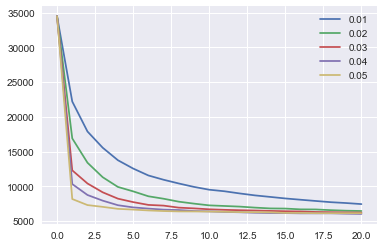

In [12]:
Stolog=StochasticLogisticRegression(1/2)
l_rates= [0.01*i for i in range(1,6)]
Lr_curves=[]

for lr in l_rates:
    print 'Fitting with lr={}'.format(lr)
    Stolog.fit(w8a_train_x,w8a_train_y, np.zeros(301), lr=lr, bsize=50,max_iter=20)
    Lr_curves.append(Stolog.f_history)

for i in Lr_curves:
    plt.plot(i)

plt.legend(l_rates)


#### Commentary:

As the learning increase between 0.01 and 0.05, the descent is steeper towards the minimum (unique by convexity) of the loss function. However, specifying too big a learning rate would cause inefficiency in the convergence towards the minimum of the loss function.

### 2 - Accelerations strategies 

Fitting with acceleration=none
Fitting done in 16.1111938953 sec
Fitting with acceleration=momentum
Fitting done in 15.5061461926 sec
Fitting with acceleration=SAG
Fitting done in 16.5588560104 sec


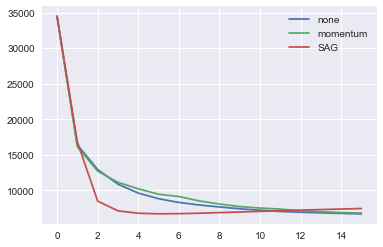

In [15]:
Stolog=StochasticLogisticRegression(1/2)
accelerations= ['none','momentum','SAG']
acce_curves=[]

for acc in accelerations:
    print 'Fitting with acceleration={}'.format(acc)
    Stolog.fit(w8a_train_x,w8a_train_y, np.zeros(301), lr=0.01, bsize=100,max_iter=15,acceleration=acc)
    acce_curves.append(Stolog.f_history)

for i in acce_curves:
    plt.plot(i)

plt.legend(accelerations)

#### Commentary

Our acceleration strategies proved to be quicker in reaching loss function minimum. Momentum technique has a marginal impact on loss function trajectory while SAG technique is converging appreciably quicker (however it introduces a bias after too many iterations as the loss function is increasing on the plot after 8 iterations)

### 3 - Prediction of test set with different batch size

In [13]:
sizes= [10,50,100,500]
size_time=[]
accuracies=[]

for size in sizes:
    print 'Fitting with batch size={}'.format(size)
    Stolog=StochasticLogisticRegression(1)
    Stolog.fit(w8a_train_x,w8a_train_y, np.zeros(301), lr=0.01, bsize=size, max_iter=15)
    size_time.append(Stolog.time)
    accuracies.append(accuracy_score(Stolog.predict(w8a_test_x),w8a_test_y))
    print '{} % of accuracy'.format(accuracies[-1]*100)

Fitting with batch size=10
Fitting done in 12.7829048634 sec
96.9632107023 % of accuracy
Fitting with batch size=50
Fitting done in 13.5909438133 sec
97.0234113712 % of accuracy
Fitting with batch size=100
Fitting done in 14.2778530121 sec
96.7157190635 % of accuracy


Text(0,0.5,'accuracy score')

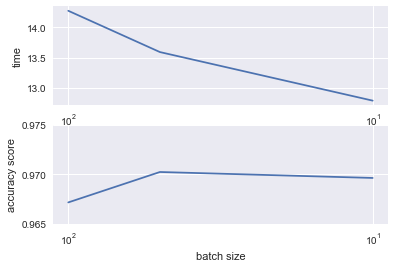

In [14]:
plt.subplot(211)
plt.plot(sizes,size_time)
ax = plt.gca()
ax.set_xscale('log')
ax.invert_xaxis()
ax.set_xlabel('batch size')
ax.set_ylabel('time')

plt.subplot(212)
plt.plot(sizes,accuracies)
ax = plt.gca()
ax.set_ylim(0.965,0.975)
ax.set_xscale('log')
ax.invert_xaxis()
ax.set_xlabel('batch size')
ax.set_ylabel('accuracy score')

As we supposed, **prediction's accuracy is positevely impacted by increasing batch size**. However, **reducing the batch size accelerate computation** of the iterations. This validates the techniques of using batches instead of the whole dataset to modify beta but underlines the **trade-off between accuracy and computation time** when setting batch size.

**Conclusion**:

In this lab session, we studied that impact of differents parameters on the rapidity and accuracy of the optimisation of a logistic regression function with stochastic gradient descent. Our implementation is obviously far less efficient in terms of time than the scikit-learn implementation, however it provides approximately the same predictions. As a conclusion, **tunning of hyper-parameters appears to be of first importance when performing optimisation** of our loss function.